In [ ]:
!hadoop fs -copyToLocal -f /ga_customer_revenue_prediction_2017_10_01-09.csv ./
!hadoop fs -copyToLocal -f /ga_customer_revenue_prediction_2017_10_10-19.csv ./
!hadoop fs -copyToLocal -f /ga_customer_revenue_prediction_train_v2_new.lightbm.model ./

In [2]:
import pandas as pd
old = pd.read_csv('ga_customer_revenue_prediction_2017_10_01-09.csv/'
                  'part-00000-c07b775e-c7c6-4351-9e18-5d797406f199-c000'
                  '.csv')
new = pd.read_csv('ga_customer_revenue_prediction_2017_10_10-19.csv/'
                  'part-00000-43cd69bc-a9b9-4028-9937-737b9c663af4-c000'
                  '.csv')
old2 = old.groupby('leaf').agg(['mean', 'count']).transactionRevenue
new2 = new.groupby('leaf').agg(['mean', 'count']).transactionRevenue
df = old2.join(new2, lsuffix='_old', rsuffix='_new')
df['delta'] = (df.mean_new - df.mean_old) * df.count_new
df.sort_values('delta', ascending=False, inplace=True)
print(old.transactionRevenue.mean(), new.transactionRevenue.mean())
print((df.mean_new * df.count_new).sum() / df.count_new.sum())
df.head()

623250.9604165468 991015.2557210316
991015.2557210316


,mean_old,count_old,mean_new,count_new,delta
leaf,,,,,
19.0,2.724761e+05,1466,2.057943e+06,1624,2.899599e+09
3.0,6.453495e+06,578,8.574566e+06,703,1.491113e+09
0.0,5.343117e+06,1463,6.220659e+06,1289,1.131152e+09
14.0,0.000000e+00,531,1.324107e+06,672,8.898000e+08
11.0,2.371514e+06,218,6.975946e+06,185,8.518200e+08


In [12]:
2.899599e+09 / df.delta.sum() * 100

57.06776386551988

In [5]:
print(df.head().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      mean\_old &  count\_old &      mean\_new &  count\_new &         delta \\
leaf &               &            &               &            &               \\
\midrule
19.0 &  2.724761e+05 &       1466 &  2.057943e+06 &       1624 &  2.899599e+09 \\
3.0  &  6.453495e+06 &        578 &  8.574566e+06 &        703 &  1.491113e+09 \\
0.0  &  5.343117e+06 &       1463 &  6.220659e+06 &       1289 &  1.131152e+09 \\
14.0 &  0.000000e+00 &        531 &  1.324107e+06 &        672 &  8.898000e+08 \\
11.0 &  2.371514e+06 &        218 &  6.975946e+06 &        185 &  8.518200e+08 \\
\bottomrule
\end{tabular}



Finished loading model, total used 1 iterations


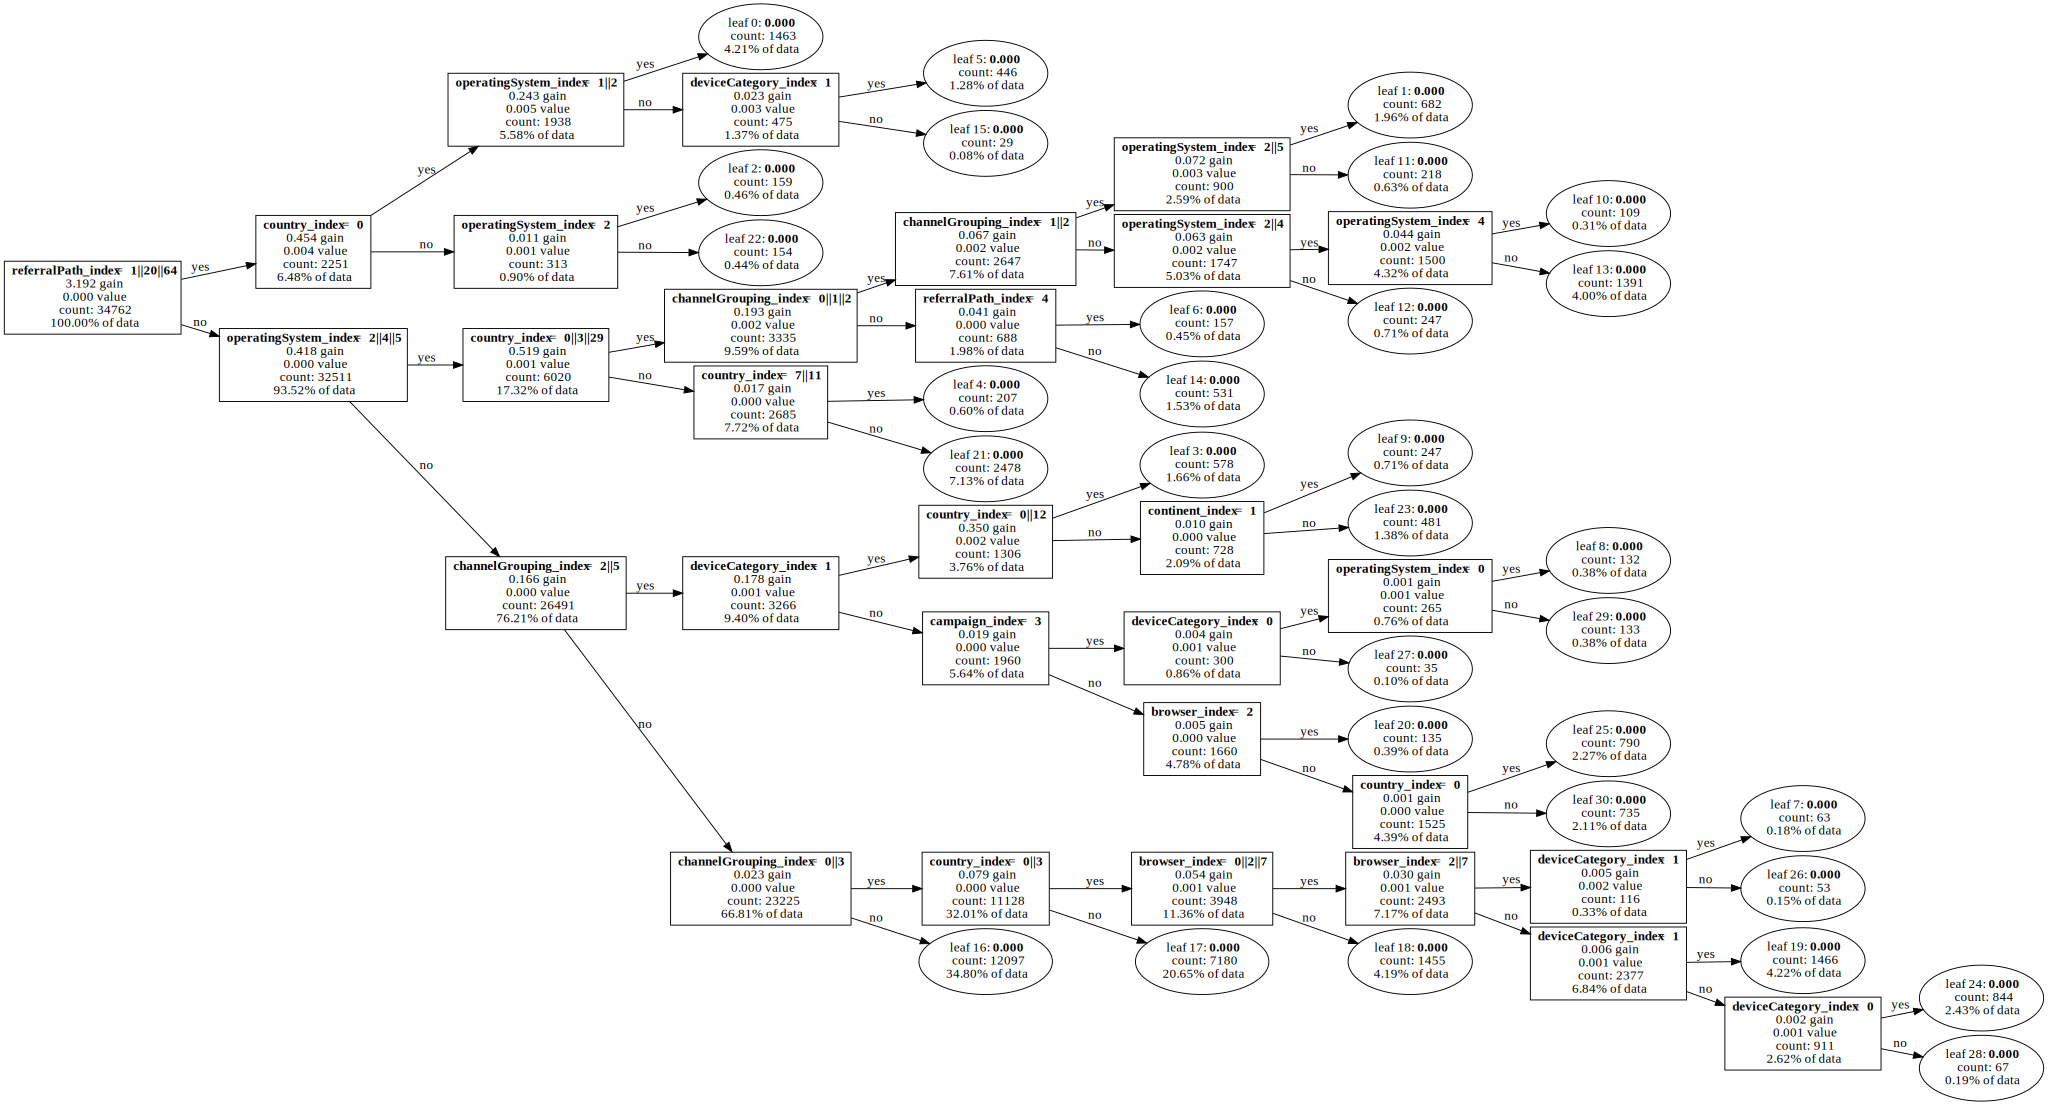

In [3]:
import lightgbm
model = open('ga_customer_revenue_prediction_train_v2_new.lightbm.model/'
             'part-00000-8a03ab76-0ca1-471f-9b7c-14e921bc9546-c000.txt').read()
graph = lightgbm.create_tree_digraph(
    lightgbm.Booster(model_str=model),
    show_info=['split_gain', 
               'internal_value',
               'internal_count', #'internal_weight',
               'leaf_count', #'leaf_weight', 
               'data_percentage'],
)
graph